In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from numpy.random import seed
seed(1337)

import tensorflow as tf
tf.random.set_seed(42)

import pickle

# from tensorflow.python.keras.applications import vgg16
from tensorflow.keras.applications import ResNet152V2
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report

In [2]:
# If this is not set, bug because tf takes too much memory
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
train_data_dir = "dataset/Train"
val_data_dir = "dataset/Validation"
test_data_dir = "dataset/Test"
category_names = sorted(os.listdir('dataset/Train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'dataset/Train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))

In [4]:
img_height, img_width = 224,224
horizontal_flip = True
rotation_range = 20
width_shift_range = 0.2
height_shift_range = 0.2

In [5]:
#conv_base = vgg16.VGG16(weights='imagenet', include_top=False,
#                        pooling='max',
#                        input_shape = (img_width, img_height, 3))

conv_base = ResNet152V2(include_top=False,
                        pooling='avg',
                        input_shape=(img_width, img_height, 3),
                        weights='imagenet')

In [6]:
# Disabling all conv_base layers for training
conv_base.trainable = False

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 2048)              58331648  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               245880    
Total params: 62,773,880
Trainable params: 4,442,232
Non-trainable params: 58,331,648
_________________________________________________________________


In [8]:
#Number of images to load at each iteration
batch_size = 32

# Rescaling and horizontal flip
train_datagen =  ImageDataGenerator(
    horizontal_flip=horizontal_flip,
    rotation_range=rotation_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)

# these are generators for train/test data that will read pictures 
# found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(
val_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 12348 images belonging to 120 classes.
Total number of images for "validation":
Found 4116 images belonging to 120 classes.
Total number of images for "testing":
Found 4116 images belonging to 120 classes.


In [9]:
learning_rate = 5e-5
epochs = 200
steps_per_epoch = int(12000 / (batch_size))
validation_steps = int(1200 / (batch_size))
test_steps = int(1200 / (batch_size))

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5,
                                                mode='max',
                                                restore_best_weights=True)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate,
                                        clipnorm = 1.),
              metrics=['acc'])

In [10]:
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    shuffle=True, 
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[callback]
                    )

Epoch 1/200
375/375 [==============================] - 104s 278ms/step - loss: 2.9253 - acc: 0.3553 - val_loss: 1.0787 - val_acc: 0.7238
Epoch 2/200
375/375 [==============================] - 102s 271ms/step - loss: 1.3996 - acc: 0.6218 - val_loss: 0.8689 - val_acc: 0.7449
Epoch 3/200
375/375 [==============================] - 102s 271ms/step - loss: 1.1739 - acc: 0.6687 - val_loss: 0.7448 - val_acc: 0.7804
Epoch 4/200
375/375 [==============================] - 102s 271ms/step - loss: 1.0203 - acc: 0.7046 - val_loss: 0.7397 - val_acc: 0.7765
Epoch 5/200
375/375 [==============================] - 101s 270ms/step - loss: 0.9617 - acc: 0.7209 - val_loss: 0.8241 - val_acc: 0.7356
Epoch 6/200
375/375 [==============================] - 101s 270ms/step - loss: 0.8937 - acc: 0.7412 - val_loss: 0.6513 - val_acc: 0.8083
Epoch 7/200
375/375 [==============================] - 101s 270ms/step - loss: 0.8526 - acc: 0.7496 - val_loss: 0.6993 - val_acc: 0.7807
Epoch 8/200
375/375 [====================

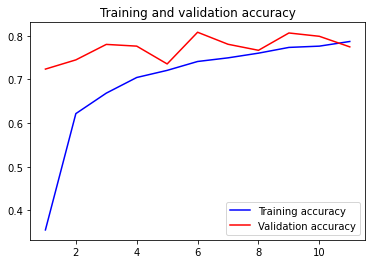

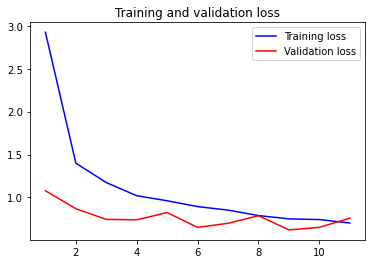

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')

In [12]:
loss, acc = model.evaluate(test_generator, steps=test_steps, verbose=0)

In [13]:
acc

0.7820945978164673

In [14]:
model.save('/home/mlmaster/Code/Ing_ml_P6/modelBase/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/mlmaster/Code/Ing_ml_P6/modelBase/assets


In [18]:
classes = (train_generator.class_indices)
classes = dict((v,k) for k,v in classes.items())

In [20]:
import csv
with open('classes.csv', 'w') as f:
    for key in classes.keys():
        f.write("%s,%s\n"%(key,classes[key]))

# Fine Tuning

In [21]:
# reset our data generators
train_generator.reset()
val_generator.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in conv_base.layers[470:]:
    layer.trainable = True

In [22]:
learning_rate = 5e-5
epochs = 200
steps_per_epoch = int(12000 / (batch_size))
validation_steps = int(1200 / (batch_size))
test_steps = int(1200 / (batch_size))

In [23]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5,
                                            mode='max',
                                            restore_best_weights=True)

# Recompiling the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate,
                                        clipnorm = 1.),
              metrics=['acc'])

In [24]:
# Retraining the model
history = model.fit(train_generator,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    shuffle=True, 
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    callbacks=[callback]
                    )

Epoch 1/200
375/375 [==============================] - 105s 280ms/step - loss: 1.5316 - acc: 0.6198 - val_loss: 0.9835 - val_acc: 0.7475
Epoch 2/200
375/375 [==============================] - 101s 270ms/step - loss: 1.2935 - acc: 0.6526 - val_loss: 0.9062 - val_acc: 0.7466
Epoch 3/200
375/375 [==============================] - 102s 273ms/step - loss: 1.2241 - acc: 0.6613 - val_loss: 0.8822 - val_acc: 0.7948
Epoch 4/200
375/375 [==============================] - 102s 272ms/step - loss: 1.1351 - acc: 0.6801 - val_loss: 1.0547 - val_acc: 0.7679
Epoch 5/200
375/375 [==============================] - 102s 273ms/step - loss: 1.1002 - acc: 0.6941 - val_loss: 1.0950 - val_acc: 0.7264
Epoch 6/200
375/375 [==============================] - 102s 272ms/step - loss: 1.0488 - acc: 0.7039 - val_loss: 0.9155 - val_acc: 0.7872
Epoch 7/200
375/375 [==============================] - 102s 272ms/step - loss: 1.0155 - acc: 0.7101 - val_loss: 1.0413 - val_acc: 0.7628
Epoch 8/200
375/375 [====================

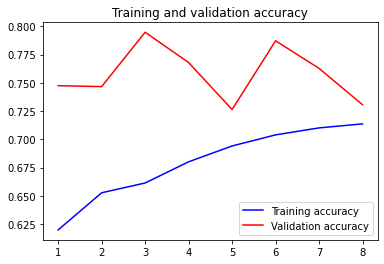

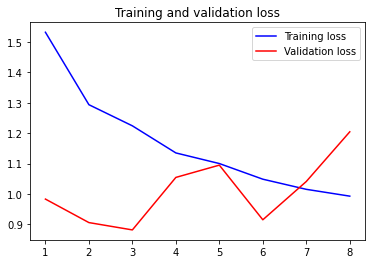

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('Accuracy.jpg')

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('Loss.jpg')

In [26]:
loss, acc = model.evaluate(test_generator, steps=test_steps, verbose=0)

In [27]:
acc

0.7457770109176636

In [28]:
model.save('/home/mlmaster/Code/Ing_ml_P6/modelFineTuning/')

INFO:tensorflow:Assets written to: /home/mlmaster/Code/Ing_ml_P6/modelFineTuning/assets


In [29]:
import keras
from numba import cuda
# Clearing session as we will train model many time
keras.backend.clear_session()
# Releasing gpu memory directly with cuda
cuda.select_device(0)
cuda.close()